# Agent Based Models

Code examples from [Think Complexity, 2nd edition](https://thinkcomplex.com).

Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from utils import decorate, savefig

## Schelling's model

`locs_where` is a wrapper on `np.nonzero` that returns results as a list of tuples.

In [5]:
def locs_where(condition):
    """Find cells where a logical array is True.
    
    condition: logical array
    
    returns: list of location tuples
    """
    return list(zip(*np.nonzero(condition)))

Here's my implementation of Schelling's model:

In [6]:
from scipy.signal import correlate2d
from Cell2D import Cell2D, draw_array

from matplotlib.colors import LinearSegmentedColormap

# make a custom color map
palette = sns.color_palette('muted')
colors = 'white', palette[1], palette[0]
cmap = LinearSegmentedColormap.from_list('cmap', colors)


class Schelling(Cell2D):
    """Represents a grid of Schelling agents."""
    
    options = dict(mode='same', boundary='wrap')

    kernel = np.array([[1, 1, 1],
                       [1, 0, 1],
                       [1, 1, 1]], dtype=np.int8)
    
    def __init__(self, n, p):
        """Initializes the attributes.

        n: number of rows
        p: threshold on the fraction of similar neighbors
        """
        self.p = p
        # 0 is empty, 1 is red, 2 is blue
        choices = np.array([0, 1, 2], dtype=np.int8)
        probs = [0.1, 0.45, 0.45]
        self.array = np.random.choice(choices, (n, n), p=probs)

    def count_neighbors(self):
        """Surveys neighboring cells.
        
        returns: tuple of
            empty: True where cells are empty
            frac_red: fraction of red neighbors around each cell
            frac_blue: fraction of blue neighbors around each cell
            frac_same: fraction of neighbors with the same color
        """
        a = self.array
        
        empty = a==0
        red = a==1
        blue = a==2

        # count red neighbors, blue neighbors, and total
        num_red = correlate2d(red, self.kernel, **self.options)
        num_blue = correlate2d(blue, self.kernel, **self.options)
        num_neighbors = num_red + num_blue

        # compute fraction of similar neighbors
        frac_red = num_red / num_neighbors
        frac_blue = num_blue / num_neighbors
        
        # no neighbors is considered the same as no similar neighbors 
        # (this is an arbitrary choice for a rare event)
        frac_red[num_neighbors == 0] = 0
        frac_blue[num_neighbors == 0] = 0
        
        # for each cell, compute the fraction of neighbors with the same color
        frac_same = np.where(red, frac_red, frac_blue)

        # for empty cells, frac_same is NaN
        frac_same[empty] = np.nan
        
        return empty, frac_red, frac_blue, frac_same

    def segregation(self):
        """Computes the average fraction of similar neighbors.
        
        returns: fraction of similar neighbors, averaged over cells
        """
        _, _, _, frac_same = self.count_neighbors()
        return np.nanmean(frac_same)
    
    def step(self):
        """Executes one time step.
                
        returns: fraction of similar neighbors, averaged over cells
        """
        a = self.array
        empty, _, _, frac_same = self.count_neighbors()
        
        # find the unhappy cells (ignore NaN in frac_same)
        with np.errstate(invalid='ignore'):
            unhappy = frac_same < self.p
        unhappy_locs = locs_where(unhappy)
        
        # find the empty cells
        empty_locs = locs_where(empty)

        # shuffle the unhappy cells
        if len(unhappy_locs):
            np.random.shuffle(unhappy_locs)
            
        # for each unhappy cell, choose a random destination
        num_empty = np.sum(empty)
        for source in unhappy_locs:
            i = np.random.randint(num_empty)
            dest = empty_locs[i]
            
            # move
            a[dest] = a[source]
            a[source] = 0
            empty_locs[i] = source
        
        # check that the number of empty cells is unchanged
        num_empty2 = np.sum(a==0)
        assert num_empty == num_empty2
        
        # return the average fraction of similar neighbors
        return np.nanmean(frac_same)
        
    def draw(self):
        """Draws the cells."""
        return draw_array(self.array, cmap=cmap, vmax=2)

Here's a small example.

0.49355500821018056

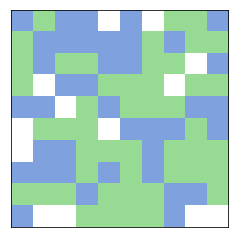

In [4]:
grid = Schelling(n=10, p=0.3)
grid.draw()
grid.segregation()

And here's an animation for a bigger example:

The degree of segregation increases quickly.

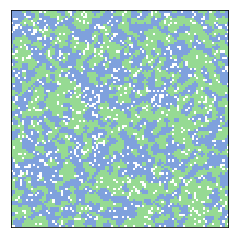

In [5]:
grid = Schelling(n=100, p=0.3)
grid.animate(frames=30, interval=0.1)

The following figure shows the process after 2 and 10 steps.

Saving figure to file figs/chap09-1


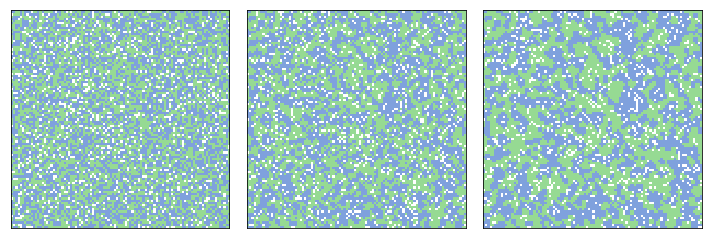

In [6]:
from utils import three_frame

grid = Schelling(n=100, p=0.3)
three_frame(grid, [0, 2, 8])

savefig('figs/chap09-1')

And here's how segregation in steady state relates to `p`, the threshold on the fraction of similar neighbors.

0.5 0.8707797990077598 0.3707797990077598
0.4 0.8181252110773387 0.4181252110773387
0.3 0.7538847395404771 0.4538847395404771
0.2 0.5729593164353953 0.3729593164353953
Saving figure to file figs/chap09-2


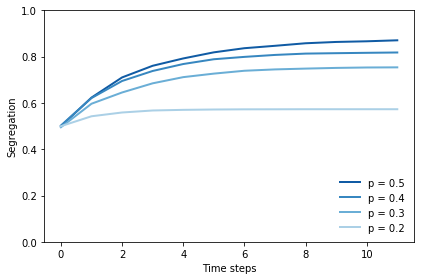

In [7]:
from utils import set_palette
set_palette('Blues', 5, reverse=True)

np.random.seed(17)
for p in [0.5, 0.4, 0.3, 0.2]:
    grid = Schelling(n=100, p=p)
    segs = [grid.step() for i in range(12)]
    plt.plot(segs, label='p = %.1f' % p)
    print(p, segs[-1], segs[-1] - p)
    
decorate(xlabel='Time steps', ylabel='Segregation',
                loc='lower right', ylim=[0, 1])

savefig('figs/chap09-2')

At `p=0.3`, there is a striking difference between the level that would make people happy, at only 30%, and the level they actually get, around 75%.

**Exercise:** Experiment with different starting conditions: for example, more or fewer empty cells, or unequal numbers of red and blue agents.

## Sugarscape

`make_locs` takes the dimensions of the grid and returns an array where each row is a coordinate in the grid.

In [7]:
def make_locs(n, m):
    """Makes array where each row is an index in an `n` by `m` grid.
    
    n: int number of rows
    m: int number of cols
    
    returns: NumPy array
    """
    t = [(i, j) for i in range(n) for j in range(m)]
    return np.array(t)

In [9]:
make_locs(2, 3)

array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2]])

`make_visible_locs` takes the range of an agents vision and returns an array where each row is the coordinate of a visible cell.

The cells are at increasing distances.  The cells at each distance are shuffled. 

In [8]:
def make_visible_locs(vision):
    """Computes the kernel of visible cells.
        
    vision: int distance
    """
    def make_array(d):
        """Generates visible cells with increasing distance."""
        a = np.array([[-d, 0], [d, 0], [0, -d], [0, d]])
        np.random.shuffle(a)
        return a
                     
    arrays = [make_array(d) for d in range(1, vision+1)]
    return np.vstack(arrays)

In [11]:
make_visible_locs(2)

array([[ 0,  1],
       [ 1,  0],
       [ 0, -1],
       [-1,  0],
       [ 0, -2],
       [-2,  0],
       [ 0,  2],
       [ 2,  0]])

`distances_from` returns an array that contains the distance of each cell from the given coordinates.

In [9]:
def distances_from(n, i, j):
    """Computes an array of distances.
    
    n: size of the array
    i, j: coordinates to find distance from
    
    returns: array of float
    """
    X, Y = np.indices((n, n))
    return np.hypot(X-i, Y-j)

In [13]:
dist = distances_from(5, 2, 2)
dist

array([[2.82842712, 2.23606798, 2.        , 2.23606798, 2.82842712],
       [2.23606798, 1.41421356, 1.        , 1.41421356, 2.23606798],
       [2.        , 1.        , 0.        , 1.        , 2.        ],
       [2.23606798, 1.41421356, 1.        , 1.41421356, 2.23606798],
       [2.82842712, 2.23606798, 2.        , 2.23606798, 2.82842712]])

I use `np.digitize` to set the capacity in each cell according to the distance from the peak.  Here's an example that shows how it works.

In [22]:
bins = [3,2,1,0]
np.digitize(dist, bins)

array([[1, 1, 1, 1, 1],
       [1, 2, 2, 2, 1],
       [1, 2, 3, 2, 1],
       [1, 2, 2, 2, 1],
       [1, 1, 1, 1, 1]], dtype=int64)

Here's my implementation of Sugarscape:

In [10]:
class Sugarscape(Cell2D):
    """Represents an Epstein-Axtell Sugarscape."""
    
    def __init__(self, n, **params):
        """Initializes the attributes.

        n: number of rows and columns
        params: dictionary of parameters
        """
        self.n = n
        self.params = params
        
        # track variables
        self.agent_count_seq = []
    
        # make the capacity array
        self.capacity = self.make_capacity()
        
        # initially all cells are at capacity
        self.array = self.capacity.copy()
        
        # make the agents
        self.make_agents()
        
    def make_capacity(self):
        """Makes the capacity array."""
        
        # compute the distance of each cell from the peaks. 
        dist1 = distances_from(self.n, 15, 15)
        dist2 = distances_from(self.n, 35, 35)
        dist = np.minimum(dist1, dist2)
        
        # cells in the capacity array are set according to dist from peak
        bins = [21, 16, 11, 6]
        a = np.digitize(dist, bins)
        return a
        
    def make_agents(self):
        """Makes the agents."""
        
        # determine where the agents start and generate locations
        n, m = self.params.get('starting_box', self.array.shape)
        locs = make_locs(n, m)
        np.random.shuffle(locs)

        # make the agents
        num_agents = self.params.get('num_agents', 400)
        assert(num_agents <= len(locs))
        self.agents = [Agent(locs[i], self.params) 
                       for i in range(num_agents)]
        
        # keep track of which cells are occupied
        self.occupied = set(agent.loc for agent in self.agents)
            
    def grow(self):
        """Adds sugar to all cells and caps them by capacity."""
        grow_rate = self.params.get('grow_rate', 1)
        self.array = np.minimum(self.array + grow_rate, self.capacity)
        
    def look_and_move(self, center, vision):
        """Finds the visible cell with the most sugar.
        
        center: tuple, coordinates of the center cell
        vision: int, maximum visible distance
        
        returns: tuple, coordinates of best cell
        """
        # find all visible cells
        locs = make_visible_locs(vision)
        locs = (locs + center) % self.n
        
        # convert rows of the array to tuples
        locs = [tuple(loc) for loc in locs]
        
        # select unoccupied cells
        empty_locs = [loc for loc in locs if loc not in self.occupied]
        
        # if all visible cells are occupied, stay put
        if len(empty_locs) == 0:
            return center
        
        # look up the sugar level in each cell
        t = [self.array[loc] for loc in empty_locs]
        
        # find the best one and return it
        # (in case of tie, argmax returns the first, which
        # is the closest)
        i = np.argmax(t)
        return empty_locs[i]
    
    def harvest(self, loc):
        """Removes and returns the sugar from `loc`.
        
        loc: tuple coordinates
        """
        sugar = self.array[loc]
        self.array[loc] = 0
        return sugar
    
    def step(self):
        """Executes one time step."""
        replace = self.params.get('replace', False)
        
        # loop through the agents in random order
        random_order = np.random.permutation(self.agents)
        for agent in random_order:
            
            # mark the current cell unoccupied
            self.occupied.remove(agent.loc)
            
            # execute one step
            agent.step(self)

            # if the agent is dead, remove from the list
            if agent.is_starving() or agent.is_old():
                self.agents.remove(agent)
                if replace:
                    self.add_agent()
            else:
                # otherwise mark its cell occupied
                self.occupied.add(agent.loc)

        # update the time series
        self.agent_count_seq.append(len(self.agents))
        
        # grow back some sugar
        self.grow()
        return len(self.agents)
    
    def add_agent(self):
        """Generates a new random agent.
                
        returns: new Agent
        """
        new_agent = Agent(self.random_loc(), self.params)
        self.agents.append(new_agent)
        self.occupied.add(new_agent.loc)
        return new_agent
    
    def random_loc(self):
        """Choose a random unoccupied cell.
        
        returns: tuple coordinates
        """
        while True:
            loc = tuple(np.random.randint(self.n, size=2))
            if loc not in self.occupied:
                return loc

    def draw(self):
        """Draws the cells."""
        draw_array(self.array, cmap='YlOrRd', vmax=9, origin='lower')
        
        # draw the agents
        xs, ys = self.get_coords()
        self.points = plt.plot(xs, ys, '.', color='red')[0]
    
    def get_coords(self):
        """Gets the coordinates of the agents.
        
        Transforms from (row, col) to (x, y).
        
        returns: tuple of sequences, (xs, ys)
        """
        agents = self.agents
        rows, cols = np.transpose([agent.loc for agent in agents])
        xs = cols + 0.5
        ys = rows + 0.5
        return xs, ys

And here's a viewer that displays the state of Sugarscape.

Here's my implementation of the agents.

In [11]:
class Agent:
    
    def __init__(self, loc, params):
        """Creates a new agent at the given location.
        
        loc: tuple coordinates
        params: dictionary of parameters
        """
        self.loc = tuple(loc)
        self.age = 0

        # extract the parameters
        max_vision = params.get('max_vision', 6)
        max_metabolism = params.get('max_metabolism', 4)
        min_lifespan = params.get('min_lifespan', 10000)
        max_lifespan = params.get('max_lifespan', 10000)
        min_sugar = params.get('min_sugar', 5)
        max_sugar = params.get('max_sugar', 25)
        
        # choose attributes
        self.vision = np.random.randint(1, max_vision+1)
        self.metabolism = np.random.uniform(1, max_metabolism)
        self.lifespan = np.random.uniform(min_lifespan, max_lifespan)
        self.sugar = np.random.uniform(min_sugar, max_sugar)

    def step(self, env):
        """Look around, move, and harvest.
        
        env: Sugarscape
        """
        self.loc = env.look_and_move(self.loc, self.vision)
        self.sugar += env.harvest(self.loc) - self.metabolism
        self.age += 1

    def is_starving(self):
        """Checks if sugar has gone negative."""
        return self.sugar < 0
    
    def is_old(self):
        """Checks if lifespan is exceeded."""
        return self.age > self.lifespan

Here's an example with `n=50`, starting with 400 agents.

[[0 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]]


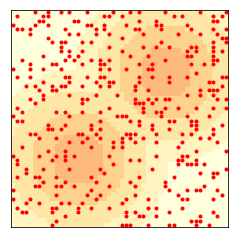

In [26]:
env = Sugarscape(50, num_agents=400)
env.draw()

The distribution of vision is uniform from 1 to 6.

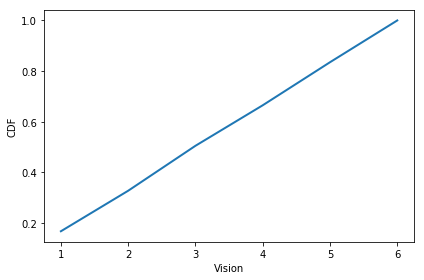

In [30]:
from empiricaldist import Cdf

cdf = Cdf.from_seq(agent.vision for agent in env.agents)
cdf.plot()
decorate(xlabel='Vision', ylabel='CDF')

The distribution of metabolism is uniform from 1 to 4.

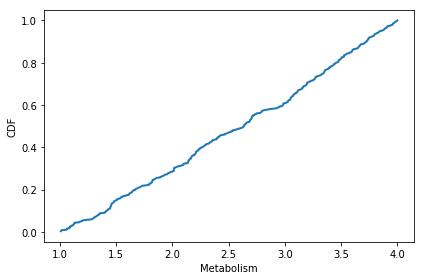

In [28]:
cdf = Cdf.from_seq(agent.metabolism for agent in env.agents)
cdf.plot()
decorate(xlabel='Metabolism', ylabel='CDF')

The distribution of initial endowment of sugar is uniform from 5 to 25.

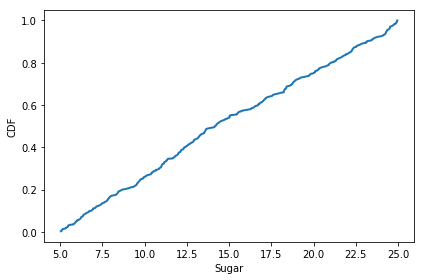

In [29]:
cdf = Cdf.from_seq(agent.sugar for agent in env.agents)
cdf.plot()
decorate(xlabel='Sugar', ylabel='CDF')

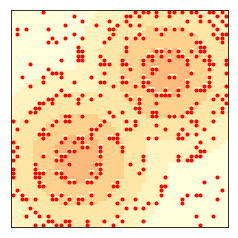

In [31]:
env.step()
env.draw()

Here's what the animation looks like.

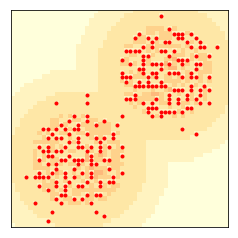

In [32]:
env.animate(frames=50)

The number of agents levels off at the "carrying capacity":

In [33]:
len(env.agents)

238

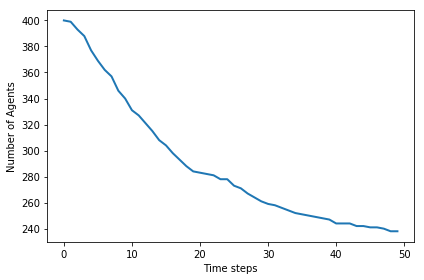

In [34]:
plt.plot(env.agent_count_seq)
decorate(xlabel='Time steps', ylabel='Number of Agents')

This figure shows the state of the system after 2 and 10 steps.

[[0 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]]
Saving figure to file figs/chap09-3


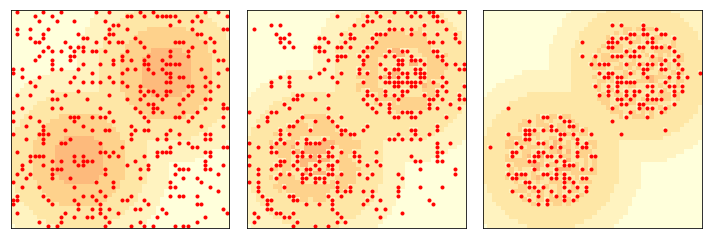

In [35]:
env = Sugarscape(50, num_agents=400)
three_frame(env, [0, 2, 98])

savefig('figs/chap09-3')

**Exercise:** Experiment with different numbers of agents.  Try increasing or decreasing their vision or metabolism, and see what effect is has on carrying capacity.

[[0 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]]


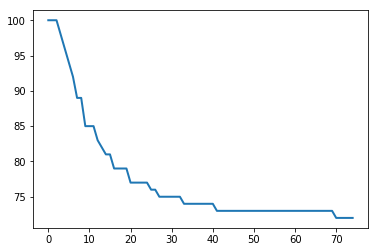

In [36]:
env = Sugarscape(50, num_agents=100)
for i in range(75):
    env.step()
plt.plot(env.agent_count_seq)

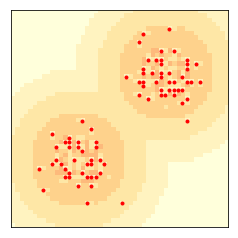

80

In [38]:
env = Sugarscape(50, num_agents=100)
env.animate(frames=50)
len(env.agents)

It is interesting to see that seeing the simulation with a number of agents that is less than the carrying capacity, we still see a decrease in the final number of living agents. This is because some unfit agents that are unlucky enough to start further away from the center will always die out. Because there is no mechanism for replacement of agents, or growth of agents (at least one that is enabled in this particular simulation), the population levels off as before.

## Sugarscape with finite lifespans

Now we start with 250 agents, with lifetimes from 60 to 100, and replacement.

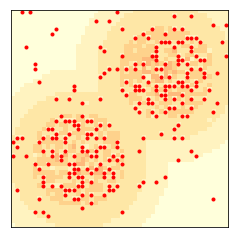

In [39]:
env = Sugarscape(50, num_agents=250,
                 min_lifespan=60, max_lifespan=100, 
                 replace=True)

env.animate(frames=100)

After 100 time steps, the distribution of wealth is skewed to the right.  Most agents have very little sugar, but a few have a lot.

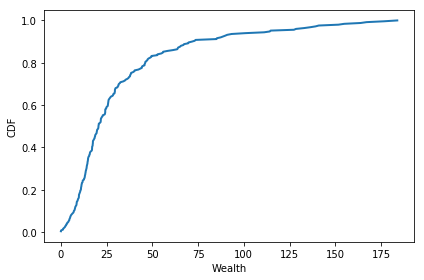

In [40]:
cdf = Cdf.from_seq(agent.sugar for agent in env.agents)
cdf.plot()
decorate(xlabel='Wealth', ylabel='CDF')

In [42]:
cdf.quantile([0.25, 0.50, 0.75, 0.90])

NotImplementedError: next is unsupported: Use fitpack routines for other types.

Starting with the same parameters, I'll run the model 500 steps, recording the distribution of wealth after each 100 steps:

In [43]:
np.random.seed(17)

env = Sugarscape(50, num_agents=250,
                 min_lifespan=60, max_lifespan=100, 
                 replace=True)

cdf = Cdf.from_seq(agent.sugar for agent in env.agents)
cdfs = [cdf]
for i in range(5):
    env.loop(100)
    cdf = Cdf.from_seq(agent.sugar for agent in env.agents)
    cdfs.append(cdf)

[[0 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]]


After about 200 steps, the distribution is stationary (doesn't change over time).

On a log scale, it is approximately normal, possibly with a truncated right tail.

Saving figure to file figs/chap09-4


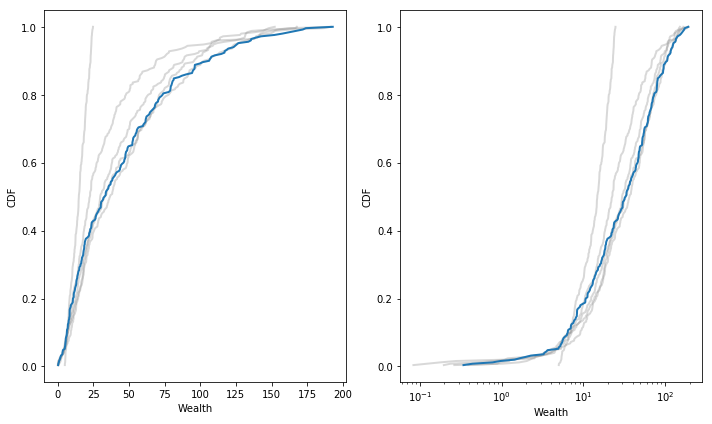

In [44]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)

def plot_cdfs(cdfs, **options):
    for cdf in cdfs:
        cdf.plot(**options)
        
plot_cdfs(cdfs[:-1], color='gray', alpha=0.3)
plot_cdfs(cdfs[-1:], color='C0')
decorate(xlabel='Wealth', ylabel='CDF')

plt.subplot(1, 2, 2)
plot_cdfs(cdfs[:-1], color='gray', alpha=0.3)
plot_cdfs(cdfs[-1:], color='C0')
decorate(xlabel='Wealth', ylabel='CDF', xscale='log')

savefig('figs/chap09-4')

**Exercise:** Experiment with different starting conditions and agents with different vision, metabolism, and lifespan.  What effect do these changes have on the distribution of wealth?

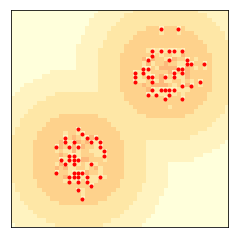

In [49]:
env = Sugarscape(50, num_agents=100,
                 min_lifespan=10, max_lifespan=500, 
                 replace=False, max_vision=25)
env.animate(50)

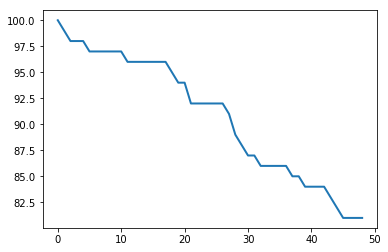

In [50]:
plt.plot(env.agent_count_seq)

Giving the agents a lot more vision really helps the population from the initial hit from trying to find the peaks of sugar

## Migration in waves

If we start with all agents in the lower left, they propagate up and to the right in waves.

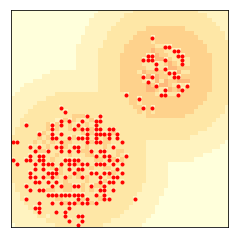

In [51]:
np.random.seed(17)

env = Sugarscape(50, num_agents=300, starting_box=(20, 20), max_vision=16)
    
env.animate(frames=20, interval=0.4)

Here's what it looks like after 6 and 12 steps.

[[0 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]]
Saving figure to file figs/chap09-5


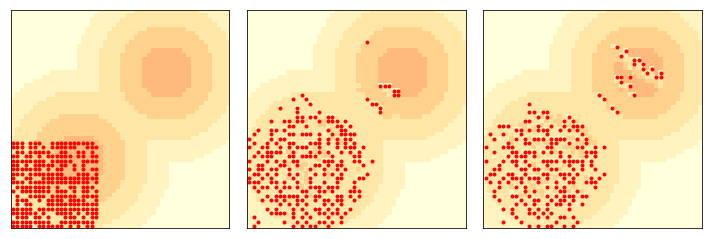

In [52]:
env = Sugarscape(50, num_agents=300, starting_box=(20, 20), max_vision=16)
three_frame(env, [0, 6, 6])
savefig('figs/chap09-5')

This example is interesting because the waves move diagonally, unlike the agents, who can only move up or to the right.  They are similar in some ways to gliders and other Game of Life spaceships. 

**Exercise:** Again, experiment with different starting conditions and see what effect they have on the wave behavior.

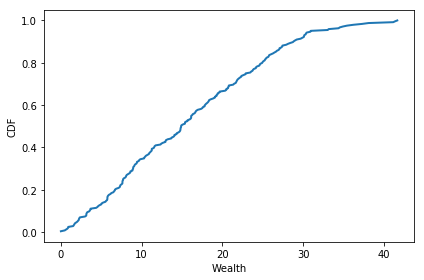

In [54]:
cdf = Cdf.from_seq(agent.sugar for agent in env.agents)
cdf.plot()
decorate(xlabel='Wealth', ylabel='CDF')

## Exercises

**Exercise:** Bill Bishop, author of *The Big Sort*, argues that
American society is increasingly segregated by political
opinion, as people choose to live among like-minded neighbors.

The mechanism Bishop hypothesizes is not that people, like the agents
in Schelling's model, are more likely to move if they are
isolated, but that when they move for any reason, they are
likely to choose a neighborhood with people like themselves.

Write a version of Schelling's model to simulate
this kind of behavior and see if it yields similar degrees of
segregation.

There are several ways you can model Bishop's hypothesis.  In my
implementation, a random selection of agents moves during each step.
Each agent considers `k` randomly-chosen empty locations and
chooses the one with the highest fraction of similar neighbors.
How does the degree of segregation depend on `k`?

You should be able to implement this model by inheriting from
`Schelling` and overriding `__init__` and `step`.



In [124]:
class Bishop(Schelling):
    kernel = np.array([[1, 1, 1],
                       [1, 0, 1],
                       [1, 1, 1]], dtype=np.int8)
    
    def __init__(self, n, k):
        choices = np.array([0, 1, 2], dtype=np.int8)
        probs = [0.1, 0.45, 0.45]
        self.k = k
        self.array = np.random.choice(choices, (n, n), p=probs)
        self.num_red = np.sum(self.array == 1)
        self.num_blue = np.sum(self.array == 2)
        self.num_empty = np.sum(self.array == 0)
        
    def step(self):
        a = self.get_random_agent()
        color = self.array[a]
        assert(color != 0)
        moves = self.get_possible_moves(k=self.k)
        similar_neighbors = sorted(self.get_similar_neighbors(moves, color), reverse=True)
        destination = similar_neighbors[0][1]
        self.array[a] = 0
        assert(self.array[destination] == 0)
        self.array[destination] = color
        
        assert(np.sum(self.array == 1) == self.num_red)
        assert(np.sum(self.array == 0) == self.num_empty)
        assert(np.sum(self.array == 2) == self.num_blue)
        
    def get_random_agent(self):
        occupied = self.array != 0
        occ_locs = locs_where(occupied)
        ind = np.random.choice(len(occ_locs), 1)[0]
        return occ_locs[ind]
        
    def get_possible_moves(self, k=10):
        empty = self.array == 0
        empty_locs = locs_where(empty)
        inds = np.random.choice(len(empty_locs), k)
        return [empty_locs[ind] for ind in inds]
    
    def get_similar_neighbors(self, positions, color):
        similar = self.array == color
        
        num_neighbors = correlate2d(similar, self.kernel, mode='same', boundary='wrap')
        return [(num_neighbors[position], position) for position in positions]
            

Text(0.5, 1.0, 'Segreation over Time Steps')

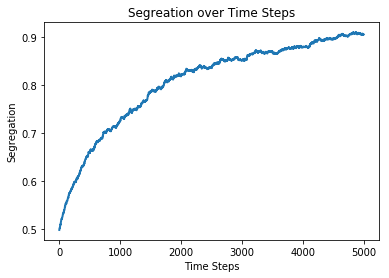

In [134]:
b = Bishop(n=30, k = 10)
segs = []
np.seterr(divide='ignore', invalid='ignore')
for i in range(5000):
    segs.append(b.segregation())
    b.step()
plt.plot(segs)
plt.xlabel('Time Steps')
plt.ylabel('Segregation')
plt.title('Segreation over Time Steps')

And a test of the `step` method

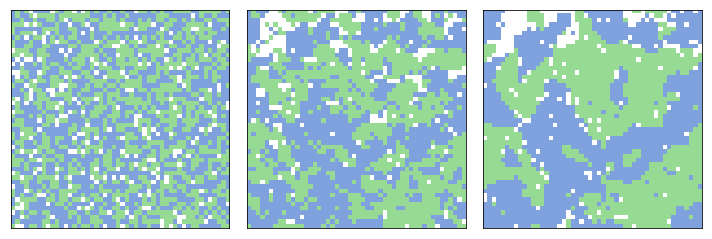

In [129]:
b = Bishop(n=50, k=10)
three_frame(b, [0, 2500, 5000])


Text(0.5, 1.0, 'Segregation over Number of Steps')

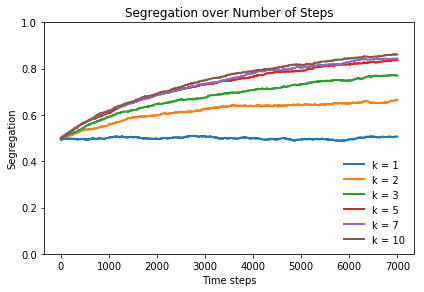

In [133]:
ks = [1,2,3,5,7,10]
for k in ks:
    b = Bishop(n=50, k=k)
    segs = []
    for i in range(7000):
        segs.append(b.segregation())
        b.step()
    plt.plot(segs, label='k = %i' % k)
    
decorate(xlabel='Time steps', ylabel='Segregation',
                loc='lower right', ylim=[0, 1])
plt.title('Segregation over Number of Steps')

It is pretty obvious that the more candidate positions that agents look at before moving, the more segregated the community becomes. However, what is surprising is just how few possible locaitons need to be considered to have a very segregated community. 

**Exercise:** In the first version of Sugarscape, we never add agents, so once the population falls, it never recovers.  In the second version, we only replace agents when they die, so the population is constant.  Now let's see what happens if we add some "population pressure".

Write a version of Sugarscape that adds a new agent at the end of every step.  Add code to compute the average vision and the average metabolism of the agents at the end of each step.  Run the model for a few hundred steps and plot the population over time, as well as the average vision and average metabolism.

You should be able to implement this model by inheriting from
`Sugarscape` and overriding `__init__` and `step`.

In [12]:
class my_sugar(Sugarscape):
    def step(self):
        # loop through the agents in random order
        random_order = np.random.permutation(self.agents)
        for agent in random_order:
            
            # mark the current cell unoccupied
            self.occupied.remove(agent.loc)
            
            # execute one step
            agent.step(self)

            # if the agent is dead, remove from the list
            if agent.is_starving() or agent.is_old():
                self.agents.remove(agent)
            else:
                # otherwise mark its cell occupied
                self.occupied.add(agent.loc)

        # update the time series
        self.agent_count_seq.append(len(self.agents))
        
        # grow back some sugar
        self.grow()
        self.add_agent()
        return len(self.agents)
    
    def calc_vision(self):
        return np.mean([agent.vision for agent in self.agents])
    def calc_metabolism(self):
        return np.mean([agent.metabolism for agent in self.agents])

[[0 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]]


Text(0, 0.5, 'Population')

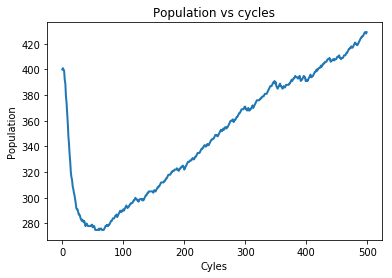

In [136]:
env = my_sugar(50, num_agents=400)
pop = []
avg_visions = []
avg_metabolisms = []
for i in range(500):
    pop.append(len(env.agents))
    avg_visions.append(env.calc_vision())
    avg_metabolisms.append(env.calc_metabolism())
    env.step()
    
plt.plot(pop)
plt.title('Population vs cycles')
plt.xlabel('Cyles')
plt.ylabel('Population')

Text(0, 0.5, 'Vision')

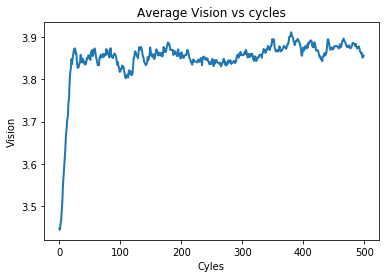

In [137]:
plt.plot(avg_visions)
plt.title('Average Vision vs cycles')
plt.xlabel('Cyles')
plt.ylabel('Vision')

Text(0, 0.5, 'Metabolism')

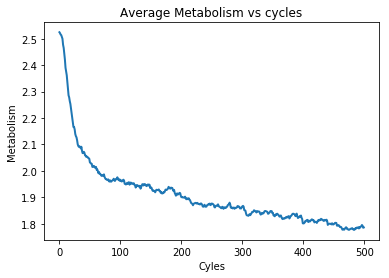

In [138]:
plt.plot(avg_metabolisms)
plt.title('Average Metabolism vs cycles')
plt.xlabel('Cyles')
plt.ylabel('Metabolism')

[[0 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]]


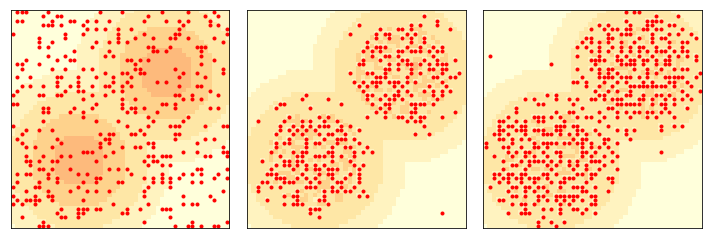

In [139]:
b = my_sugar(50, num_agents=400)
three_frame(b, [0, 250, 500])


It makes sense that the average metabolism and average vision goes down and up respectively. It is kind of surprising how quickly the average vision goes up. Although, I suppose because it doesn't change by that much from initial, it isn't *that* surprising. 

Population has an interesting response, and doesn't look like it has yet reached a steady state. I'll run it with more cycles below

Text(0, 0.5, 'Population')

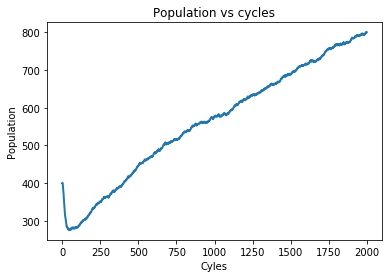

In [17]:
env = my_sugar(50, num_agents=400)
pop = []
for i in range(2000):
    pop.append(len(env.agents))
    env.step()
    
plt.plot(pop)
plt.title('Population vs cycles')
plt.xlabel('Cyles')
plt.ylabel('Population')

800


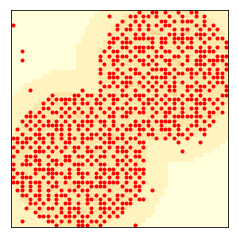

In [18]:
env.draw()
print(len(env.agents))

It seems like the upper limit for population is really high. It shows no signs of slowing even after 2000 cycles!

In [55]:
# Solution goes here